#**Homework 2 - Classification**


Binary classification is one of the most fundamental problem in machine learning. In this tutorial, you are going to build linear binary classifiers to predict whether the income of an indivisual exceeds 50,000 or not. We presented a discriminative and a generative approaches, the logistic regression(LR) and the linear discriminant anaysis(LDA). You are encouraged to compare the differences between the two, or explore more methodologies. Although you can finish this tutorial by simpliy copying and pasting the codes, we strongly recommend you to understand the mathematical formulation first to get more insight into the two algorithms. Please find [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) and [here](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf) for more detailed information about the two algorithms.

二元分類是機器學習中最基礎的問題之一，在這份教學中，你將學會如何實作一個線性二元分類器，來根據人們的個人資料，判斷其年收入是否高於 50,000 美元。我們將以兩種方法: logistic regression 與 generative model，來達成以上目的，你可以嘗試了解、分析兩者的設計理念及差別。針對這兩個演算法的理論基礎，可以參考李宏毅老師的教學投影片 [logistic regression](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf) 與 [generative model](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)。


#Dataset

This dataset is obtained by removing unnecessary attributes and balancing the ratio between positively and negatively labeled data in the [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)), which can be found in [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php). Only preprocessed and one-hot encoded data (i.e. *X_train*,  *Y_train* and *X_test*) will be used in this tutorial. Raw data (i.e. *train.csv* and *test.csv*) are provided to you in case you are interested in it.

這個資料集是由 [**UCI Machine Learning Repository**](https://archive.ics.uci.edu/ml/index.php) 的 [**Census-Income (KDD) Data Set**](https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)) 經過一些處理而得來。為了方便訓練，我們移除了一些不必要的資訊，並且稍微平衡了正負兩種標記的比例。事實上在訓練過程中，只有 X_train、Y_train 和 X_test 這三個經過處理的檔案會被使用到，train.csv 和 test.csv 這兩個原始資料檔則可以提供你一些額外的資訊。

In [2]:
import os
from google.colab import drive 
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/hw2_classification"
os.chdir(path)
os.listdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


['X_test', 'X_train', 'Y_train', 'hw2_classification.ipynb']

#Logistic Regression

In this section we will introduce logistic regression first. We only present how to implement it here, while mathematical formulation and analysis will be omitted. You can find more theoretical detail in [Prof. Lee's lecture](https://www.youtube.com/watch?v=hSXFuypLukA).

首先我們會實作 logistic regression，針對理論細節說明請參考[李宏毅老師的教學影片](https://www.youtube.com/watch?v=hSXFuypLukA)

###Preparing Data

Load and normalize data, and then split training data into **training set** and **development set**.

下載資料，並且對每個屬性做正規化，處理過後再將其切分為訓練集與發展集。

In [3]:
import numpy as np

np.random.seed(0)
X_train_fpath = 'X_train'
Y_train_fpath = 'Y_train'
X_test_fpath = 'X_test'
output_fpath = 'output_{}.csv'

# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        # axis=0，对指定列求mean，这里reshape(1, -1)应该是多余的，存疑！
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        # axis=0，对指定列求std
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510



###Some Useful Functions

Some functions that will be repeatedly used when iteratively updating the parameters.

這幾個函數可能會在訓練迴圈中被重複使用到。

In [5]:
def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def _sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))

def _f(X, w, b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    # 这里把np.matmul改成np.dot也是可以的，因为w是向量，在matmul中它当成矩阵列向量，在dot中当成普通向量，结果都是一致的
    return _sigmoid(np.matmul(X, w) + b)

def _predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    # 利用round函数的四舍五入功能把概率转化成0或1
    return np.round(_f(X, w, b)).astype(np.int)
    
def _accuracy(Y_pred, Y_label):
    # This function calculates prediction accuracy
    # 预测值和标签值相减，取绝对值后再求平均，相当于预测错误的个数(差为1)/总个数，即错误率，1-错误率即正确率
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

### Functions about gradient and loss

Please refers to [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)(p.12) for the formula of gradient and loss computation.

請參考[李宏毅老師上課投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Logistic%20Regression%20(v3).pdf)第 12 頁的梯度及損失函數計算公式。

In [11]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    # cross_entropy = -Σ(y_head*ln(y)+(1-y_head)*ln(1-y))
    # Note: 这里的np.dot将两个vector进行doc product.
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    # loss function: -Σ (y_head*ln(y)+(1-y_head)*ln(1-y)), 分别对w和b求偏微分，可得
    # gradient of w: -Σ（y_head - y)*x
    # gradient of b: -Σ（y_head - y)
    y_pred = _f(X, w, b)
    pred_error = Y_label - y_pred
    # prd_error = [batch_size, ] vector
    # X.T = [data_dim, batch_size] array

    w_grad = -np.sum(pred_error * X.T, 1) # 按列求和
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad


### Training

Everything is prepared, let's start training! 

Mini-batch gradient descent is used here, in which training data are split into several mini-batches and each batch is fed into the model sequentially for losses and gradients computation. Weights and bias are updated on a mini-batch basis.

Once we have gone through the whole training set,  the data have to be re-shuffled and mini-batch gradient desent has to be run on it again. We repeat such process until max number of iterations is reached.

我們使用小批次梯度下降法來訓練。訓練資料被分為許多小批次，針對每一個小批次，我們分別計算其梯度以及損失，並根據該批次來更新模型的參數。當一次迴圈完成，也就是整個訓練集的所有小批次都被使用過一次以後，我們將所有訓練資料打散並且重新分成新的小批次，進行下一個迴圈，直到事先設定的迴圈數量達成為止。

In [44]:
# Zero initialization for weights ans bias
#w = np.zeros((data_dim,)) 
#b = np.zeros((1,))
# 构建vector(b是只含一个数的vector) - w和b 
w = np.zeros(data_dim)
b = np.zeros(1)

# Some parameters for training    
max_iter = 40
batch_size = 5
learning_rate = 0.2

# Keep the loss and accuracy at every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calcuate the number of parameter updates
step = 1
w_adagrad = np.ones(data_dim) * (1e-8)
b_adagrad = np.ones(1) * (1e-8)

# Iterative training
for epoch in range(max_iter):
    # Random shuffle at the begging of each epoch
    X_train, Y_train = _shuffle(X_train, Y_train)
        
    # Mini-batch training
    for idx in range(train_size // batch_size):
        X = X_train[idx*batch_size: (idx+1)*batch_size]
        Y = Y_train[idx*batch_size: (idx+1)*batch_size]

        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)

        # Compute the adagrad
        w_adagrad += w_grad ** 2
        b_adagrad += b_grad ** 2
            
        # gradient descent update
        # learning rate decay with time
        
        w = w - learning_rate/np.sqrt(w_adagrad) * w_grad
        b = b - learning_rate/np.sqrt(b_adagrad) * b_grad
        step = step + 1
            
    # Compute loss and accuracy of training set and development set

    y_train_pred = _f(X_train, w, b)    # 预测值
    Y_train_pred = np.round(y_train_pred)   # 预测值取整，得到0或1
    train_acc.append(_accuracy(Y_train_pred, Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred, Y_train) / train_size)

    #Y_dev_pred = _predict(X_dev, w, b)
    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.32138354489797977
Development loss: 0.2964124849305225
Training accuracy: 0.8832387201415511
Development accuracy: 0.8809436048654626


In [45]:
Y

array([1., 1., 0., 0., 0.])

### Plotting Loss and accuracy curve

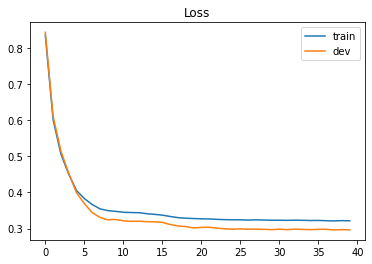

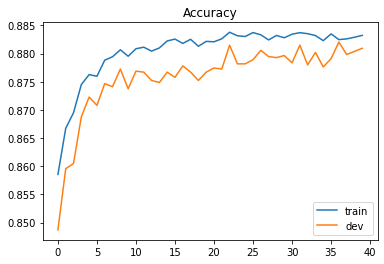

In [46]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.savefig('loss.png')
plt.show()

# Accuracy curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.savefig('acc.png')
plt.show()

###Predicting testing labels

Predictions are saved to *output_logistic.csv*.

預測測試集的資料標籤並且存在 *output_logistic.csv* 中。

In [47]:
# Predict testing labels
predictions = _predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Nonfamily householder 8.245488771377392
 Other Rel <18 never marr not in subfamily 8.222844306683504
 Grandchild <18 never marr not in subfamily 8.057250359243968
 Other Rel 18+ ever marr RP of subfamily 7.298140075214265
 Grandchild 18+ ever marr RP of subfamily 6.722646332499503
 Holand-Netherlands 6.474071576735943
 Holand-Netherlands 6.3303054506856675
 RP of unrelated subfamily 6.098665437279891
 Honduras 5.316584836611772
 Local government 4.975457700894109


# Porbabilistic generative model

In this section we will discuss a generative approach to binary classification. Again, we will not go through the formulation detailedly. Please find [Prof. Lee's lecture](https://www.youtube.com/watch?v=fZAZUYEeIMg) if you are interested in it.

接者我們將實作基於 generative model 的二元分類器，理論細節請參考[李宏毅老師的教學影片](https://www.youtube.com/watch?v=fZAZUYEeIMg)。

### Preparing Data

Training and testing data is loaded and normalized as in logistic regression. However, since LDA is a deterministic algorithm, there is no need to build a development set.

訓練集與測試集的處理方法跟 logistic regression 一模一樣，然而因為 generative model 有可解析的最佳解，因此不必使用到 development set。

In [38]:
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

### Mean and Covariance

In generative model, in-class mean and covariance are needed.

在 generative model 中，我們需要分別計算兩個類別內的資料平均與共變異。

In [39]:
# Compute in-class mean
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)  

# Compute in-class covariance
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

### Computing weights and bias

Directly compute weights and bias from in-class mean and shared variance. [Prof. Lee's lecture slides](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)(p.33) gives a concise explanation.

權重矩陣與偏差向量可以直接被計算出來，算法可以參考[李宏毅老師教學投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Classification%20(v3).pdf)第 33 頁。

In [40]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# Compute accuracy on training set
Y_train_pred = 1 - _predict(X_train, w, b)
print('Training accuracy: {}'.format(_accuracy(Y_train_pred, Y_train)))

Training accuracy: 0.8693232084930699


###Predicting testing labels

Predictions are saved to *output_generative.csv*.

預測測試集的資料標籤並且存在 *output_generative.csv* 中。

In [41]:
# Predict testing labels
predictions = 1 - _predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])


 29 -9.5791015625
 Forestry and fisheries 9.53662109375
 Retail trade 8.13671875
 7 -7.81689453125
 Finance insurance and real estate 7.6845703125
 41 -7.138671875
 Agriculture 6.975830078125
 34 -6.2109375
 37 -5.69384765625
 33 -5.6201171875
